In [40]:
import requests
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# Load APP_TOKEN vairable from keys file
from secret import APP_TOKEN

# Table of contents
* [Overview](#Overview)
* [Data](#Data)
* [Model](#Model)

## Overview

The purpose of this project is to create a model to predict the number of crimes that might occur in some chicago neighborhood on any given day. We will be using the Chicago Crimes Dataset, limiting ourselves to the date and community area fields from this set of data. 


## Data <a name="Data"></a>

In [41]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json?$select=date,community_area&$where=year<=2020 AND year >= 2010&$order=date ASC&$limit=10000000"
headers = {'Accept': 'application/json', 'X-App-Token': APP_TOKEN}
resp = requests.get(url,headers=headers)
df = json.loads(resp.text)
df = pd.DataFrame(df).dropna()
df

,date,community_area
0,2010-01-01T00:00:00.000,11
1,2010-01-01T00:00:00.000,15
2,2010-01-01T00:00:00.000,16
3,2010-01-01T00:00:00.000,2
4,2010-01-01T00:00:00.000,61
...,...,...
3184679,2020-12-31T23:45:00.000,69
3184680,2020-12-31T23:45:00.000,38
3184681,2020-12-31T23:45:00.000,32
3184682,2020-12-31T23:51:00.000,29


In [42]:
# Data pre-processing: Trasforming data to the the total number of crimes occured each day per community area

# Make a copy of the queried data
df_new = df
# The exact time of crime occured is not necessary, we only keep date data
df_new['date'] = df_new['date'].str[:10]
# rename columns
df_new.rename({'size': 'num_crimes'}, axis=1, inplace=True)
# convert to date type
df_new['date'] = pd.to_datetime(df_new['date'])

df_new

,date,community_area
0,2010-01-01,11
1,2010-01-01,15
2,2010-01-01,16
3,2010-01-01,2
4,2010-01-01,61
...,...,...
3184679,2020-12-31,69
3184680,2020-12-31,38
3184681,2020-12-31,32
3184682,2020-12-31,29


We will be creating visualizations of the data using the cumulative crime data for the city, as we will be able to detect seasonality from a city wide standpoint. Our time series analysis will proceed using cumulative data based on the month, as it would be very tricky to work with day to day seasonality.

In [43]:
# total crimes for the entire city per month
df_total_month = df_new
# convert month column into useable format
df_total_month['month'] = df_total_month['date'].dt.to_period('M')
# group number of crimes by month
df_total_month = df_total_month.groupby(df_total_month['month'], as_index=False).size()

#Set the index
df_total_month.set_index('month',inplace=True)
df_total_month.index = df_total_month.index.to_timestamp()

df_total_month

,size
month,
2010-01-01,29233
2010-02-01,24938
2010-03-01,32320
2010-04-01,31661
2010-05-01,33395
...,...
2020-08-01,19822
2020-09-01,17849
2020-10-01,18345


In [44]:
# Plot the number of crimes for the entire city per calendar month
fig = px.line(df_total_month, y="size")
fig.show()

From our preliminary plot, there appears to be a strong component of seasonality in our data and it does not appear to be multiplicative. As a result, we run a naive seasonal decomposition using an additive model.

<AxesSubplot:xlabel='month'>

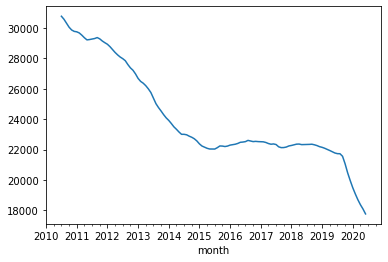

In [45]:
# display seasonal decomposition charts using the statsmodels package
result = seasonal_decompose(df_total_month["size"],  model='additive')
# plotting trend (seasonally adjusted)
result.trend.plot()

<AxesSubplot:xlabel='month'>

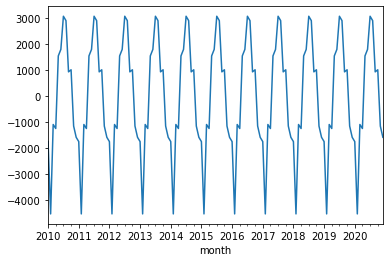

In [46]:
result.seasonal.plot()

count     120.000000
mean      -18.142361
std       968.209160
min     -4275.500694
25%      -452.954861
50%       -10.931944
75%       494.726389
max      3574.078472
Name: resid, dtype: float64

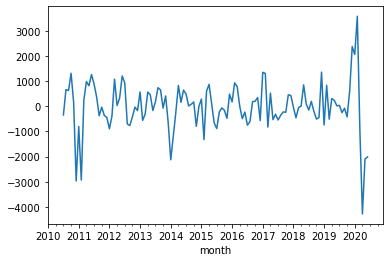

In [47]:
result.resid.plot()
result.resid.describe()

## Model <a name="Model"></a>

A naive seasonal decomposition reveals that the trend componenet of our data is not exactly linear. The mean of our residuals is approximately zero, suggesting that trend information captured by the seasonal decomposition is mostly accurate. Given the results of our exploratory analysis, running a seasonal decomposition using loess might prove successful, and an ARIMA model could be used to provide forecasting results. 

<AxesSubplot:xlabel='month'>

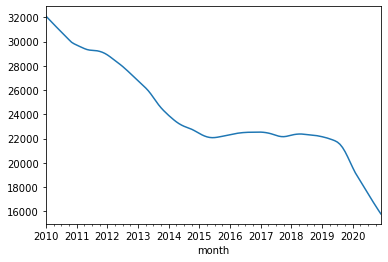

In [48]:
# run STL decomposition, seasonal attribute is set to 13 because of we are using montly data
stl = STL(df_total_month, seasonal = 13)
res = stl.fit()

# STL trend plot
res.trend.plot()

The trend of our STL decomposition is much smoother than a naive seasonal decompostion

<AxesSubplot:xlabel='month'>

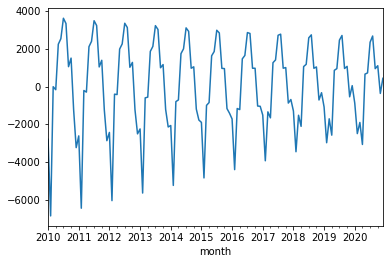

In [49]:
# STL seasonal plot
res.seasonal.plot()

count     132.000000
mean        5.103873
std       673.267397
min     -2557.262951
25%      -398.783995
50%        62.990598
75%       453.078794
max      1610.469356
Name: resid, dtype: float64

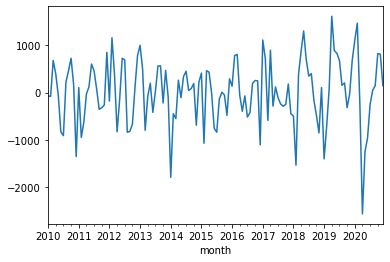

In [50]:
# STL residuals plot
res.resid.plot()
res.resid.describe()

The mean of the residuals of our STL decomposition are closer to zero now, the STL has given us less error overall. We now perform the Augmented Dickey Fuller (ADF) test to see if our timeseries is stationary.

In [51]:
# ADF test
def adfuller_test(some_ts):
    res = adfuller(some_ts)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value, label in zip(res, labels):
        print(label+' : '+str(value) )

adfuller_test(df_total_month['size'])


ADF Test Statistic : -0.2222057560491746
p-value : 0.9358224690619608
#Lags Used : 12
Number of Observations : 119


The ADF test shows that our time series is not stationary, in fact it is far from it, with a p-value of .935. We will have to manually determine the parameters for our ARIMA model. 

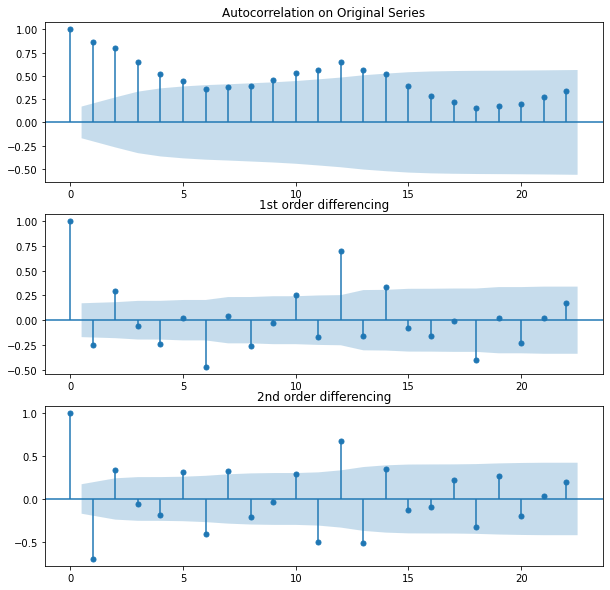

In [52]:
# finding order of differencing using auto correlation
fig = plt.figure(figsize = (10 ,10))

ax1 = fig.add_subplot(311)
fig = plot_acf(df_total_month, ax=ax1, title="Autocorrelation on Original Series")

ax2 = fig.add_subplot(312)
fig = plot_acf(df_total_month.diff().dropna(), ax=ax2, title="1st order differencing")

ax3 = fig.add_subplot(313)
fig = plot_acf(df_total_month.diff().diff().dropna(), ax=ax3, title="2nd order differencing")

Increasing the autoregressive terms seems to only increase the amount of lags above the significance level. We will progress with d = 0.

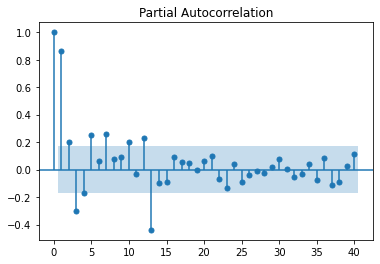

In [53]:
# Partial auto correction using d = 0
fig = plot_pacf(df_total_month, method='ywm', lags=40)

Two lags are significantly about the significance level. We will use p = 2.

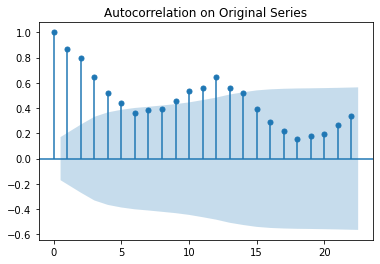

In [54]:
# Autocorrelation
fig = plot_acf(df_total_month, title="Autocorrelation on Original Series")

Two lags are found to be above the significance level, and so q = 2. Out ARIMA parameters will be p = 2, d = 0, and q = 2.

Lets generate some results based on past data and see how effective our model is.

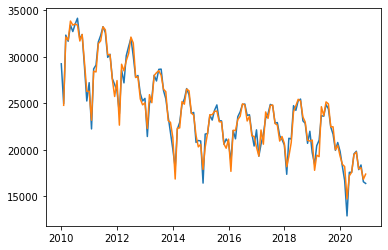

In [55]:
# Turn data frame into series so that we can work with get_prediction method
df_total_month_series = df_total_month.squeeze()

# Use STL to remove seasonalities and ARIMA to predict
stlf = STLForecast(df_total_month_series, ARIMA, model_kwargs=dict(order=(0,1,0), trend='t'))
stlf_res = stlf.fit()

# Generate predictions starting at index 1 until the most recent month
preds = stlf_res.get_prediction(start=df_total_month_series.index[1],end=df_total_month_series.index[-1])
plt.plot(df_total_month)
plt.plot(preds.predicted_mean)
plt.show()

Finally, we perform some forecasting using our model.

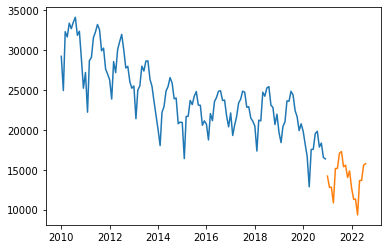

In [56]:
# Use STL to remove seasonalities and ARIMA to forecast
stlf = STLForecast(df_total_month, ARIMA, model_kwargs=dict(order=(0,1,0), trend='t'))
stlf_res = stlf.fit()

# Generate forcast for n periods
forecast = stlf_res.forecast(20)
plt.plot(df_total_month)
plt.plot(forecast)
plt.show()

In [57]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  132
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1046.727
Date:                Mon, 12 Jul 2021   AIC                           2097.454
Time:                        22:02:45   BIC                           2103.204
Sample:                    01-01-2010   HQIC                          2099.791
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -125.5843     62.518     -2.009      0.045    -248.117      -3.052
sigma2      5.111e+05   5.99e+04      8.529      0.000    3.94e+05    6.29e+05
Ljung-Box (L1) (Q):                   5.05   Jarque-

Viewing the raw forecast data

In [58]:
print(forecast)

2021-01-01    14196.373254
2021-02-01    12789.005897
2021-03-01    12819.971736
2021-04-01    10837.950845
2021-05-01    15149.670911
2021-06-01    15172.056770
2021-07-01    17081.924287
2021-08-01    17275.543900
2021-09-01    15376.490356
2021-10-01    15575.732690
2021-11-01    14031.559804
2021-12-01    14852.988613
2022-01-01    12689.361867
2022-02-01    11281.994510
2022-03-01    11312.960348
2022-04-01     9330.939457
2022-05-01    13642.659524
2022-06-01    13665.045383
2022-07-01    15574.912900
2022-08-01    15768.532513
Freq: MS, dtype: float64
